<a href="https://colab.research.google.com/github/modichirag/flowpm/blob/master/notebooks/flowpm_blog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install --quiet  git+https://github.com/modichirag/flowpm.git@blogpost;
!git clone --quiet -b blogpost https://github.com/modichirag/flowpm.git;

In [2]:
#Setup
%tensorflow_version 1.x
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import InterpolatedUnivariateSpline as iuspline
%matplotlib inline
#
import tensorflow as tf
#
from flowpm import linear_field, lpt_init, nbody, cic_paint
import flowpm

TensorFlow 1.x selected.


Let's begin by setting some fixed parameters to describe our Universe and the N-Body simulation

In [0]:
## Define key parameters of our Universe
a0      = 0.1       #the initial epoch from where we begin the evolution, a0=0 corresponds to birth but is numerically unstable
af      = 1.0       #final epoch where we visualize structures, af=1 corresponds to today
n_steps = 30        #number of time-steps to split the total evolution into
L       = 100       #Physical size of the Universe in Mpc/h
N       = 64        #Number of mesh-points along one axis, size of the cube. Then the number of particles will be N^3
batch   = 2         #Batch size, how many independent Universes to simulate

stages = np.linspace(a0, af, n_steps, endpoint=True) #time-steps for the integration

#Read-in the linear power-spectrum from a file. 
#This is determined by some fundamental parameters of our Universe that cosmologists are interested in
#In N-body simulations, this determines the clustering of the Universe at the initial epoch a0
klin = np.loadtxt('flowpm/flowpm/data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('flowpm/flowpm/data/Planck15_a1p00.txt').T[1]
ipklin = iuspline(klin, plin)


Next, we will generate a tensorflow graph for the N-body evolution. 
This graph has 3 key steps- 
1. Generating the initial conditions of the matter distribution in the Universe. This is a random Gaussian realization with the initial clustering specified by linear power spectrum.
2. From these initial conditions, generate the initial displacement and velocities of all the particles at the initial epoch (a0)
3. Evolve these particles under Newtonian gravity (N-body simulation) to their positions and velocity at final epoch (af)

For ease of visualization, we will interpolate these particles back to the N-body mesh.

In [4]:
tf.reset_default_graph()
# Generate Gaussian initial conditions for matter density 
initial_conditions = flowpm.linear_field(N,  L, ipklin, batch_size=batch)   

# Sample particles, i.e. generate the initial displacement and velocity
# State is a tensor of shape (3, batch, N^3, 3)
# where the last axiss corresponds to the 3: x, y, z directions 
# and the first axis corresponds to position, velocity, acceleration of particle
state = flowpm.lpt_init(initial_conditions, a0=a0)   

# Evolve particles from initial state down to a=af
final_state = flowpm.nbody(state, stages, N)         

# Retrieve final density field i.e interpolate the particles to the mesh
final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), final_state[0])



In [0]:
#Execute the graph!
with tf.Session() as sess:
    ic, istate, fstate, sim = sess.run([initial_conditions, state, final_state, final_field])

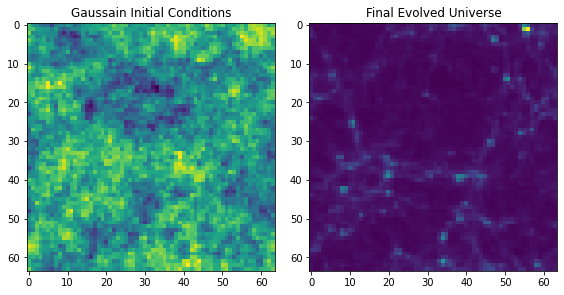

In [6]:
ib = 0  #index of the Universe in the batch

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(ic[ib].sum(axis=0))
ax[0].set_title('Gaussain Initial Conditions')
ax[1].imshow(sim[ib].sum(axis=0))
ax[1].set_title('Final Evolved Universe')
plt.tight_layout()
plt.show()


No handles with labels found to put in legend.


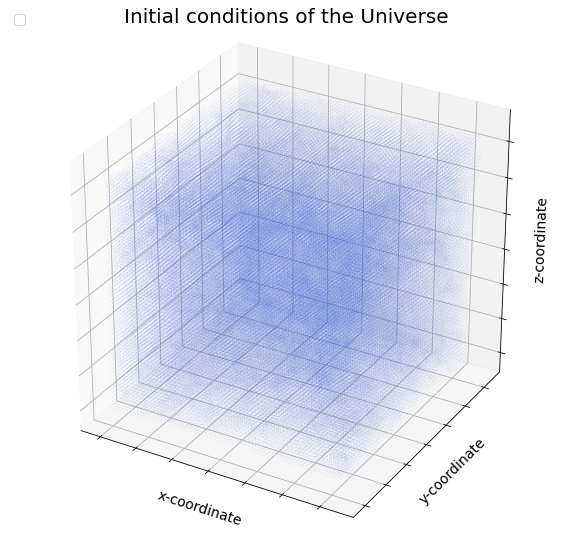

In [7]:
#Create figure
#Need to convert to physical coordinates
fig=plt.figure(figsize=(10,10))#Create 3D axes
try: ax=fig.add_subplot(111,projection="3d")
except : ax=Axes3D(fig) 
ax.scatter(istate[0, 0,:,0],istate[0, 0,:,1], istate[0, 0,:,2],color="royalblue",marker=".",s=.02)
ax.set_xlabel("x-coordinate",fontsize=14)
ax.set_ylabel("y-coordinate",fontsize=14)
ax.set_zlabel("z-coordinate",fontsize=14)
ax.set_title("Initial conditions of the Universe\n",fontsize=20)
ax.legend(loc="upper left",fontsize=14)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
plt.savefig('3dinitial.png', dpi=1200)

No handles with labels found to put in legend.


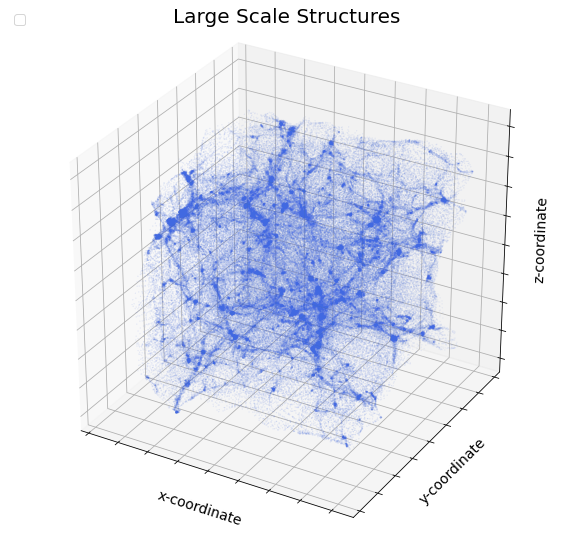

In [8]:
#Create figure
fig=plt.figure(figsize=(10,10))#Create 3D axes
try: ax=fig.add_subplot(111,projection="3d")
except : ax=Axes3D(fig) 
ax.scatter(fstate[0, 0,:,0],fstate[0, 0,:,1], fstate[0, 0,:,2],color="royalblue",marker=".",s=.02)
ax.set_xlabel("x-coordinate",fontsize=14)
ax.set_ylabel("y-coordinate",fontsize=14)
ax.set_zlabel("z-coordinate",fontsize=14)
ax.set_title("Large Scale Structures\n",fontsize=20)
ax.legend(loc="upper left",fontsize=14)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
plt.savefig('3dfinal.png', dpi=1200)